# Downloader & render for Xenium In Situ mouse brain data

This notebook downloads and renders the Xenium In Situ mouse brain data from 10x Genomics. The dataset can be accessed and viewed on the [official web page](
https://xenium.10xgenomics.com/?image=s3%2F10x.files%2Fxenium%2Fpreview%2Fmbrain%2Fexperiment.xenium&zoom=0.0197&target=24176.5_16567.5&z=12&off=&layers=cell~image&nav=true&axes=false&feature=icon&feature_psc=6&feature_ps=circles&feature_off=0_28~30_53~55_59~61_72~74_80~82_126~128_178~180_186~189_224~226_541&bin=80&d_c=Viridis&d_o=0.8&cell_bt=cell&cell_c=groups&cell_g=0&cell_o=0.5&ct_c=Viridis&ct_o=0.8&cell_v=filled).

The cell type assignments was performed by [Salas *et al*, 2024](https://www.biorxiv.org/content/10.1101/2023.02.13.528102v1).

#### variable preparation:

In [1]:
from pathlib import Path

data_folder = Path("data")
salas_folder = data_folder / "xenium-salas"
xenium_folder = data_folder / "Xenium"
replicate_section = "1"  # this is the slice, 1 is the default analyzed in the paper

xenium_path = salas_folder / "adata_multisection_nuclei_3rep_withHM_withclusters.h5ad"
segments_path = xenium_folder / "cell_boundaries.parquet"

#### Load cell segment boundaries:

In [2]:
import pandas as pd

cell_segment_boundaries = pd.read_parquet(segments_path)

#### Load cell annotations, create signatures by aggregating the slices:

In [3]:
import anndata as ad

adata_annotated_dapi = ad.read_h5ad(xenium_path)

/dh-projects/ag-ishaque/analysis/muellni/envs/sainsc/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import tqdm
from matplotlib.cm import nipy_spectral
from matplotlib.colors import ListedColormap
from matplotlib_scalebar.scalebar import ScaleBar
from rasterio.features import rasterize
from shapely.geometry import Polygon

adata_annotated_dapi_segment = adata_annotated_dapi[
    adata_annotated_dapi.obs.replicate == replicate_section
]

color_series = pd.Series(
    adata_annotated_dapi.uns["Class_colors"],
    index=adata_annotated_dapi.obs.Class.cat.categories,
)
color_series.to_json(salas_folder / "celltype_colors.json")

In [5]:
color_series = color_series.loc[
    lambda s: ~s.index.str.startswith(("Missegmented", "Noise"))
]

adata_annotated_dapi_segment = adata_annotated_dapi_segment[
    ~adata_annotated_dapi_segment.obs["Class"].str.startswith(("Missegmented", "Noise"))
]
adata_annotated_dapi_segment.obs = adata_annotated_dapi_segment.obs.assign(
    Class=lambda df: df["Class"].cat.remove_unused_categories()
)

In [6]:
cmap = ListedColormap(list(color_series.values))
celltype_to_color_index_series = pd.Series(
    np.arange(color_series.shape[0]), index=color_series.index
)
cell_id_to_color_index_series = pd.Series(
    celltype_to_color_index_series[adata_annotated_dapi_segment.obs["Class"]].values,
    index=adata_annotated_dapi_segment.obs["cell_id"],
)

# zoom factor:
um_p_px = 0.5
cell_segment_boundaries_ = cell_segment_boundaries.copy()
cell_segment_boundaries_["vertex_x"] = cell_segment_boundaries_["vertex_x"] / um_p_px
cell_segment_boundaries_["vertex_y"] = cell_segment_boundaries_["vertex_y"] / um_p_px

# Group the boundaries by cell_id
segment_boundaries_grouped = cell_segment_boundaries_.groupby("cell_id")

In [7]:
# Create polygons for each cell
polygons = []
for cell_id in tqdm.tqdm(
    adata_annotated_dapi_segment.obs["cell_id"],
    total=len(adata_annotated_dapi_segment.obs["cell_id"]),
):
    group = segment_boundaries_grouped.get_group(cell_id)

    polygon = Polygon(group[["vertex_x", "vertex_y"]].values)
    polygons.append((polygon, cell_id_to_color_index_series[cell_id]))

100%|██████████| 141463/141463 [01:07<00:00, 2085.05it/s]


In [8]:
# Define the shape of the output image
max_x = int(cell_segment_boundaries_["vertex_x"].max()) + 1
max_y = int(cell_segment_boundaries_["vertex_y"].max()) + 1
out_shape = (max_y, max_x)

# Rasterize the polygons
segmentation_map = rasterize(
    polygons, out_shape=out_shape, fill=np.nan, all_touched=False, dtype=float
)

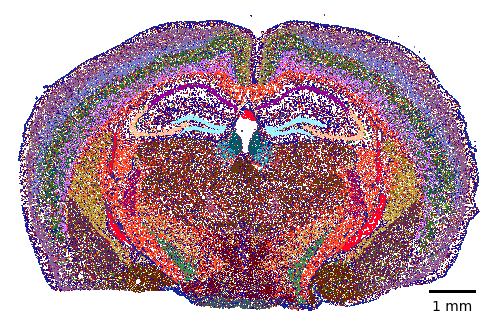

In [16]:
# Optionally visualize the result
# plt.style.use("dark_background")

fig, ax = plt.subplots(figsize=(7.5, 4), facecolor="w")
# ax = plt.subplot(111, facecolor="w")

ax.imshow(
    segmentation_map[1_000:, :],
    cmap=cmap,
    interpolation="none",
    origin="lower",
)

# legend = plt.legend(
#     *zip(
#         *[
#             (plt.Circle((0, 0), 1, color=color), celltype)
#             for celltype, color in color_series.items()
#         ]
#     ),
#     loc="upper left",
#     bbox_to_anchor=(1, 1),
#     fontsize=10,
# )
scalebar = ScaleBar(1e-6 * um_p_px, location="lower right")
_ = ax.add_artist(scalebar)
_ = ax.axis("off")

In [17]:
fig.savefig(Path("figures") / "Xenium_segmentation.pdf", dpi=600)